# RECOMMENDATION MODEL - MACHINE LEARNING

##### In this instance we proceed to develop a business recommendation model that, by entering a business category and/or state, we can suggest to the investor the best-rated business with the most relevant words among users, added to 5 other similar business recommendations.

### 1- IMPORT LIBRARIES

In [1]:
pip install wordcloud

StatementMeta(, 8e8d9aac-3e54-4c17-ada9-24f6fcd077cb, 3, Finished, Available)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.1/511.1 kB 16.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import scipy as sp
%load_ext autoreload
%autoreload 2
import builtin.utils as ut
import operator
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings("ignore")

StatementMeta(, 8e8d9aac-3e54-4c17-ada9-24f6fcd077cb, 4, Finished, Available)

___
### 2- LOAD DATA

In [3]:
df_model = pd.read_parquet('/lakehouse/default/Files/ML_Model/model.parquet')
df_info = pd.read_parquet('/lakehouse/default/Files/ML_Model/df_info.parquet')

StatementMeta(, 8e8d9aac-3e54-4c17-ada9-24f6fcd077cb, 5, Finished, Available)

In [4]:
df_model

StatementMeta(, 8e8d9aac-3e54-4c17-ada9-24f6fcd077cb, 6, Finished, Available)

,Business_Name,City,State,Category,Ranking,Distance,Tourism_Cat
0,Chick's Deli,Cherry Hill,New Jersey,Restaurant,4.5,2.322361,Shopping mall
1,Boston's Fish House & Bar,Las Vegas,Nevada,Restaurant,4.2,0.136253,Park
2,Carniceria El Ranchito,Indianapolis,Indiana,Restaurant,4.5,1.936573,Shopping mall
3,Krispy Kreme,Mishawaka,Indiana,Restaurant,4.2,0.857562,Shopping mall
4,Nana Thai,Washington,District of Columbia,Restaurant,4.2,1.678742,Park
...,...,...,...,...,...,...,...
995,373 American Grill,Sewell,New Jersey,Restaurant,4.5,1.630732,Park
996,Fabrica Pizza,Tampa,Florida,Shopping mall,4.5,0.000000,Shopping mall
997,Bay Biryanis,Mountain View,California,Restaurant,4.6,0.116384,Art gallery
998,The Crafter’s Library,Santa Barbara,California,Pub,5.0,0.077684,Art gallery


##### Define the business recommendation function, by using cosine similarity.

In [5]:
# Combine relevant columns into a single text column
df_model['combined_features'] = df_model['Business_Name'] + ' ' + df_model['State'] + ' ' + df_model['Category']+' '+ df_model['Tourism_Cat']

# Initialize the vectorizer TF-IDF
tfidf_vectorizer = TfidfVectorizer()

# Wrap and transform combined text into an array TF-IDF
tfidf_matrix = tfidf_vectorizer.fit_transform(df_model['combined_features'])

# Calculate the cosine similarity between all rows of the matrix TF-IDF
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

def get_recommendations(business_name, cosine_sim=cosine_sim, df=df_model):
    # Get the index of the business with the given name
    idx = df[df['Business_Name'] == business_name].index[0]
    
    # Obtener pares de similitud coseno para el negocio dado
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # Get cosine similarity pairs for the given business
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Obtain the indexes of the 5 most similar businesses (excluding the business itself)
    similar_indices = [i[0] for i in sim_scores[1:6]]
    
    # Get the names and categories of the 5 most similar businesses
    similar_businesses = df[['Business_Name', 'State', 'Category']].iloc[similar_indices]
    
    return similar_businesses

StatementMeta(, 8e8d9aac-3e54-4c17-ada9-24f6fcd077cb, 7, Finished, Available)

##### Define the function that, by entering status and category, returns the business with the highest ranking.

In [6]:
def find_businesses(state, category=None):
    if category:
        # Filter the main DataFrame by status and category
        filtered_df = df_model[(df_model['State'] == state) & (df_model['Category'] == category)]
    else:
        # Filter parent DataFrame by state only
        filtered_df = df_model[df_model['State'] == state]
        
    if filtered_df.empty:
        return None
    
    if category:
        # Filter to ensure there are different Tourism_Cat values ​​for each business
        filtered_df = filtered_df.drop_duplicates(subset='Tourism_Cat')
        # Sort by distance and take the first 3 businesses
        recommended_businesses = filtered_df.sort_values(by='Distance').head(3)
    else:
        # For each category, select the business with the highest ranking
        top_ranked_businesses = filtered_df.groupby('Category').apply(lambda x: x.nlargest(1, 'Ranking'))
        recommended_businesses = top_ranked_businesses.reset_index(drop=True)
    
    # Return only the desired columns
    return recommended_businesses[['Business_Name', 'State', 'Category']]

StatementMeta(, 8e8d9aac-3e54-4c17-ada9-24f6fcd077cb, 8, Finished, Available)

##### Define the function that, once the particular business is mentioned, returns a wordcloud with customer comments

In [7]:
from IPython.display import display

def get_business_info(business_name):
    # Find the business in the DataFrame df_info
    business_info = df_info[df_info['Business_Name'] == business_name]
    
    if business_info.empty:
        return None
    
    # Get feedback from business customers
    comments = business_info['Text'].values.tolist()
    
    # Concatenate all comments into a single text
    text = ' '.join(comments)
    
    # Generate the wordcloud of the comments
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    # Exclude 'Text' column from business information
    business_info = business_info.drop(columns=['Text'])
    
    # Exclude 'Text' column from business information
    business_info = business_info.drop_duplicates()
    
    # Show the wordcloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Deshabilita los ejes
    plt.show()
    
    # Convert the wordcloud to an image
    img = wordcloud.to_image()
    
    # Convert business_info and recommendations to DataFrames
    business_info_df = pd.DataFrame(business_info)
    recommendations_df = pd.DataFrame(get_recommendations(business_name))
    
    # Show DataFrames as tables with titles
    business_info = display(business_info_df.style.set_caption("Business Info"))
    recommendations = display(recommendations_df.style.set_caption("Other Business Recommendations"))
    
    return business_info, img, recommendations


StatementMeta(, 8e8d9aac-3e54-4c17-ada9-24f6fcd077cb, 9, Finished, Available)

##### Verify the correct use of the proposed functions

In [8]:
State = 'California'
Category = 'Pub'
find_businesses(State, Category)

StatementMeta(, 8e8d9aac-3e54-4c17-ada9-24f6fcd077cb, 10, Finished, Available)

,Business_Name,State,Category
133,Black Diamond Tavern,California,Pub
171,Woodhouse Blending & Brewing,California,Pub
81,MCG Service LLC,California,Pub


In [9]:
State = 'New York'
Category = None
find_businesses(State, Category)

StatementMeta(, 8e8d9aac-3e54-4c17-ada9-24f6fcd077cb, 11, Finished, Available)

,Business_Name,State,Category
0,Blue Mountain Reservation Trail Lodge,New York,Hostel
1,Rainbow Dog Hotel & Day Care,New York,Hotel
2,Rosie Dunn's Victorian Pub,New York,Pub
3,Sushi Nonaka,New York,Restaurant


StatementMeta(, 8e8d9aac-3e54-4c17-ada9-24f6fcd077cb, 12, Finished, Available)

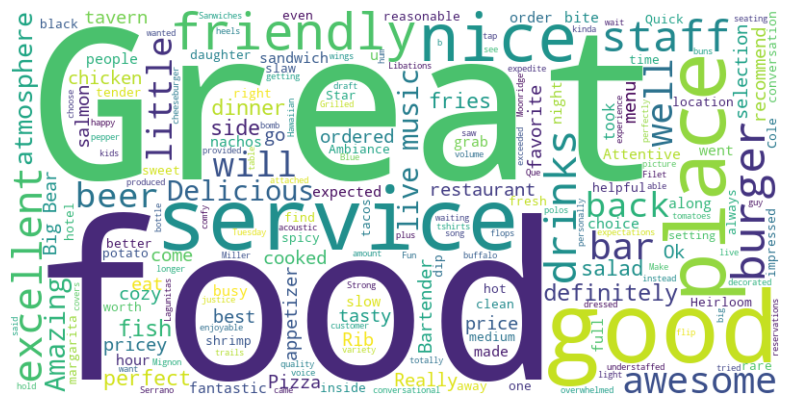

,Business_Name,Address,City,State,Category,Distance,Closest_Touristic_Business,Tourism_Cat,Ranking
66084,Black Diamond Tavern,"Black Diamond Tavern, 42172 Moonridge Way, Big Bear Lake, CA 92315",Big Bear Lake,California,Pub,0.839082,Trails End,Park,4.100000


,Business_Name,State,Category
7,Tiburon Tavern,California,Restaurant
798,Huntsman Tavern,Nevada,Pub
208,Chapel Tavern,Nevada,Pub
468,HOB Tavern,New Jersey,Pub
549,Foothills Tavern,Nevada,Restaurant


(None, <PIL.Image.Image image mode=RGB size=800x400>, None)

In [10]:
get_business_info("Black Diamond Tavern")